# Estimating nitrogen concentrations in streams and rivers using NN

Antonio Fonseca

GeoComput & ML

May 20th, 2021

Exercise base on the: 

**[Estimating nitrogen and phosphorus concentrations in streams and rivers, within a machine learning framework](https://www.nature.com/articles/s41597-020-0478-7)**

Longzhu Q. Shen, Giuseppe Amatulli, Tushar Sethi, Peter Raymond & Sami Domisch  
Scientific Data volume 7, Article number: 161 (2020)  

Lecture: [Artificial Neural Networks for geo-data](http://spatial-ecology.net/docs/source/lectures/lect_20210520_NNs_day1.pdf)

## Introduction

The field of deep learning begins with the assumption that everything is a function, and leverages powerful tools like Gradient Descent to efficiently learn these functions. Although many deep learning tasks (like classification) require supervised learning (with labels, testing, and training sets), a rich subset of the field has developed potent methods for automated, non-linear unsupervised learning, in which all you need to provide is the data. These unsupervised methods include Autoencoders, Variational Autoencoders, and Generative Adversarial Networks. They can be used to visualize data or to compress it; to generate novel data, and even to learn the functions underlying your data. In this assignment, you'll gain hands-on experience using simple networks to perform classification and regression on a variety of datasets, and will then apply these techniques to generate new samples using Variational Autoencoders and GANs. 

This assignment will also serve as a hands-on introduction to PyTorch. At present, PyTorch is the single most popular machine learning library in Python. It provides a framework of pre-built classes and helper functions to greatly simplify the creation of neural networks and their paraphernalia. Before PyTorch and its ilk, machine learning researchers were known to spend days juggling weight and bias vectors, or tediously implementing their own data processing functions. With PyTorch, this takes minutes. 

Before diving into this assignment, you'll need to install PyTorch and some other important packages (see below). The PyTorch website provides an interactive quick-start guide to tailor the installation to your system's configuration https://pytorch.org/get-started/locally/. (The installation instructions will ask you to install torchvision in addition to torch. Thankfully we have a VM prepared for you!)


Needed packages for this lecture:
```
conda install pandas
conda install -c conda-forge scikit-learn 
conda install -c anaconda seaborn
conda install -c conda-forge tensorflow
conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
conda install ipywidgets
```


**BackGround**

- Geoenviornmental variables  
- Ground observationd : Nitrogen in US streams  


In [1]:
import numpy as np
import codecs
import os
import copy
import json
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
from sklearn import manifold
import pandas as pd 
from torch.nn import functional as F


import pandas as pd
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,RandomSampler
from torchvision import datasets, transforms
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Loading data and Logistic Regression

In [2]:
# Loading the dataset and create dataloaders
mnist_train = datasets.MNIST(root = 'data', train=True, download=True, transform = transforms.ToTensor())
mnist_test = datasets.MNIST(root = 'data', train=False, download=True, transform = transforms.ToTensor())


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...


/home/user/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [3]:
# Prepare the dataset
class MyDataset(Dataset):
    def __init__(self, data, target):
        
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [1]:
def DataPreProcessing(verbose=False):
    dataset = pd.read_csv("/media/sf_LVM_shared/my_SE_data/exercise/txt/US_TN_season_1_proc.csv")	
    
    #Check for NaN in this table and drop them if there are
    dataset.isna().sum()
    dataset.dropna()

    # Remove extra variables from the dataset (keep just the 47 predictors and the 'bcmean' (what we are predicting)
    dataset = dataset.drop(["RVunif_bc","mean","std","cv","longitude","latitude","RVunif"],axis=1)
    if verbose:
        print('Example of the dataset: \n',dataset.head())

    dataset_orig = dataset.copy()

    # Rescale: differences in scales accross input variables may increase the difficulty of the problem being modeled and results on unstable weights for connections
    sc = MinMaxScaler(feature_range = (0,1)) #Scaling features to a range between 0 and 1

    # Scaling and translating each feature to our chosen range
    dataset = sc.fit_transform(dataset) 
    dataset = pd.DataFrame(dataset, columns = dataset_orig.columns)
    if verbose:
        print('dataset (after transform): \n',dataset.head())
    dataset_scaled = dataset.copy() #Just backup
    inverse_data = sc.inverse_transform(dataset) #just to make sure it works
    inverse_data = pd.DataFrame(inverse_data, columns = dataset_orig.columns)
    if verbose: 
        print('inverse_data: \n',inverse_data.head())
    

    #Check the overall stats
    train_stats = dataset.describe()
    train_stats.pop('bcmean') #because that is what we are trying to predict
    train_stats = train_stats.transpose()
    if verbose: print('train_stats: ',train_stats) #now train_stats has 47 predictors (as described in the paper).

    
    labels = dataset.pop('bcmean')
    if verbose: print('labels.describe: ',labels.describe())
    dataset = MyDataset(dataset.to_numpy(), labels.to_numpy())
    dataset_size  = len(dataset)
    if verbose: print('dataset_size: {}'.format(dataset_size))
    validation_split=0.3

    batch_size=25 #How many samples are actually going to be selected

    # -- split dataset
    indices       = list(range(dataset_size))
    split         = int(np.floor(validation_split*dataset_size))
    if verbose: print('samples in validation: {}'.format(split))
    np.random.shuffle(indices) # Randomizing the indices is not a good idea if you want to model the sequence
    train_indices, val_indices = indices[split:], indices[:split]

    # -- create dataloaders
    train_sampler = RandomSampler(train_indices)
    valid_sampler = RandomSampler(val_indices)

    dataloaders   = {
        'train': torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1, sampler=train_sampler),
        'val': torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1, sampler=valid_sampler),
        'test': torch.utils.data.DataLoader(dataset,  batch_size=dataset_size, num_workers=1, shuffle=False),
        'all_val': torch.utils.data.DataLoader(dataset, batch_size=split, num_workers=1, shuffle=True),
        }


    if verbose: 
        #Inspect the original mean (still missing some formatting)
        sns.set()
        f, (ax1,ax2) = plt.subplots(2, 1,sharex=True)
        sns.distplot(labels,hist=True,kde=False,bins=75,color='darkblue',  ax=ax1, axlabel=False)
        sns.kdeplot(labels,bw=0.15,legend=True,color='darkblue', ax=ax2)

        ax1.set_title('Original  histogram')
        ax1.legend(['bcmean'])
        ax2.set_title('KDE')
        ax2.set_xlabel('Mean Concentration N')
        ax1.set_ylabel('Count')
        ax2.set_ylabel('Dist')
        
    # Inspect the joint distribution of a few pairs of columns from the training set
    # We can observe that the process of scalling the data did not affect the skewness of the data
    if verbose: 
        sns.pairplot(dataset_scaled[["lc09", "lc07", "hydro05", "hydro07","soil01","dem"]], diag_kind="kde")
        plt.show()
        
    return dataloaders



Example of the dataset: 
    lc01  lc02  lc03  lc04  lc05  lc06  lc07  lc08  lc09  lc10  ...   hydro14  \
0    66     0     1    33     0     0     0     0     0     0  ...      4418   
1    53     0     2    43     0     0     0     0     0     0  ...      3710   
2    28     0    15    45    23    22    12     0     0     0  ...  38819396   
3    59     0     2    33     0     0     6     0     0     0  ...      7735   
4    52     0     2    43     0     0     1     0     0     0  ...      3999   

   hydro15    hydro16    hydro17    hydro18    hydro19   dem  slope  order  \
0       68     182937      21313     182937      21313   498    407      2   
1       68     155202      18107     155202      18107   365    402      2   
2       29  310689856  136347296  310689856  136347296  1470    492      8   
3       67     302169      37266     302169      37266   342    467      2   
4       68     167904      19575     167904      19575   341    391      2   

     bcmean  
0 -1.43559

/home/user/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/user/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.15 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


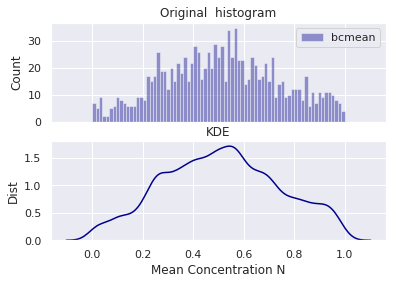

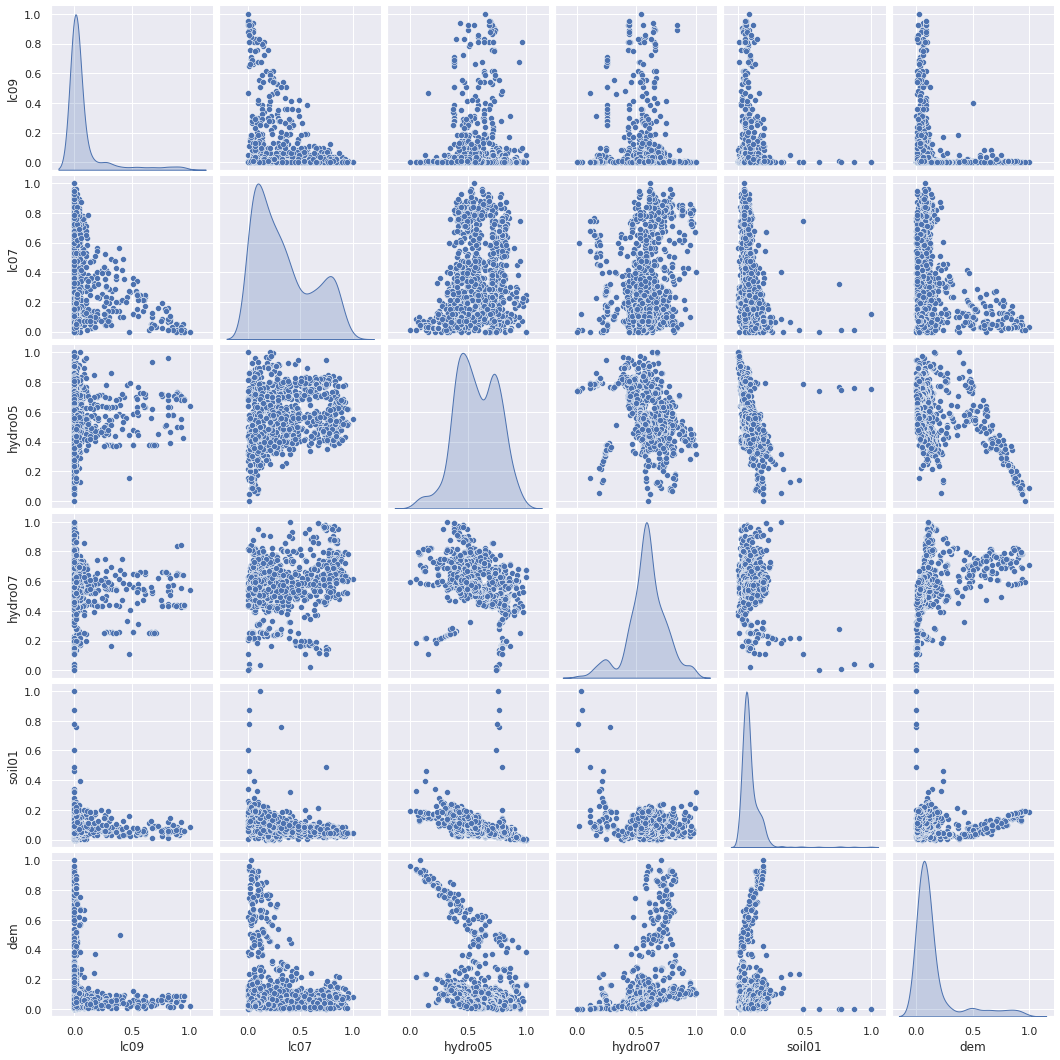

Dim of raw sample image: torch.Size([25, 47])

Dim of labels: torch.Size([25])

max 1.0, min 0.0
max_labels 0.9762871265411377, min 0.10735689848661423


In [6]:
dataloaders = DataPreProcessing(verbose=True)

#Check out how the dataloeader works
dataiter = iter(dataloaders['val'])
samples_tmp, labels_tmp = dataiter.next()

print('Dim of raw sample image: {}\n'.format(samples_tmp.shape))
print('Dim of labels: {}\n'.format(labels_tmp.shape))
print('max {}, min {}'.format(torch.max(samples_tmp),torch.min(samples_tmp)))
print('max_labels {}, min {}'.format(torch.max(labels_tmp),torch.min(labels_tmp)))

In [7]:
# Training and Evaluation routines
def train(model,loss_fn, optimizer, train_loader, test_loader, config_str, num_epochs=None, verbose=False):
    """
    This is a standard training loop, which leaves some parts to be filled in.
    INPUT:
    :param model: an untrained pytorch model
    :param loss_fn: e.g. Cross Entropy loss of Mean Squared Error.
    :param optimizer: the model optimizer, initialized with a learning rate.
    :param training_set: The training data, in a dataloader for easy iteration.
    :param test_loader: The testing data, in a dataloader for easy iteration.
    """
    
    path_to_save = './plots'
    if not os.path.exists(path_to_save):
        os.makedirs(path_to_save)
    
    print('optimizer: {}'.format(optimizer))
    if num_epochs is None:
        num_epochs = 100 
    print('n. of epochs: {}'.format(num_epochs))
    train_loss=[]
    val_loss=[]
    r2train=[]
    r2val=[]
    for epoch in range(num_epochs+1):
        # loop through each data point in the training set
        all_loss_train=0
        for data, targets in train_loader:
            start = time.time()
            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose: 
                print('model_input.shape: {}'.format(model_input.shape))
                print('model_input: {}'.format(model_input))
                
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            
            out = model(model_input).squeeze()
            if verbose:
                print('targets: {}'.format(targets.shape))
                print('out: {}'.format(out.shape))

            # Calculate the loss
            targets = targets.to(device) # add an extra dimension to keep CrossEntropy happy.
            if verbose: print('targets.shape: {}'.format(targets.shape))
            loss = loss_fn(out,targets)
            if verbose: print('loss: {}'.format(loss))
            
            # Find the gradients of our loss via backpropogation
            loss.backward()

            # Adjust accordingly with the optimizer
            optimizer.step()
            all_loss_train += loss.item()
        train_loss.append(all_loss_train/len(train_loader))
            
        with torch.no_grad():
            all_loss_val=0
            for data, targets in test_loader:

                # run the model on the data
                model_input = data.view(data.size(0),-1).to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
                out = model(model_input).squeeze()
                targets = targets.to(device) # add an extra dimension to keep CrossEntropy happy.
                loss = loss_fn(out,targets)
                all_loss_val += loss.item()
            val_loss.append(all_loss_val/len(test_loader))
                    
        
        # Give status reports every 100 epochs
        if epoch % 10==0:
            print(f" EPOCH {epoch}. Progress: {epoch/num_epochs*100}%. ")
            r2train.append(evaluate(model,train_loader,verbose))
            r2val.append(evaluate(model,test_loader,verbose))
            print(" Training R^2: {:.4f}. Test R^2: {:.4f}. Loss Train: {:.4f}. Loss Val: {:.4f}. Time: {:.4f}".format(r2train[-1], r2val[-1], 
                                                                                                                train_loss[-1], val_loss[-1], 10*(time.time() - start))) #TODO: implement the evaluate function to provide performance statistics during training.
            
    # Plot 
    plt.close('all')
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(np.arange(num_epochs+1),train_loss, label='Training')
    ax[0].plot(np.arange(num_epochs+1),val_loss, label='Test')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(np.arange(0,num_epochs+1,10),r2train, label='Training')
    ax[1].plot(np.arange(0,num_epochs+1,10),r2val, label='Test')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    plt.show()
    print('saving ', os.path.join(path_to_save,  config_str + '.png'))
    fig.savefig(os.path.join(path_to_save, config_str + '.png'), bbox_inches='tight')

def evaluate(model, evaluation_set, verbose=False):
    """
    Evaluates the given model on the given dataset.
    Returns the percentage of correct classifications out of total classifications.
    """
    with torch.no_grad(): # this disables backpropogation, which makes the model run much more quickly.
        r_score = []
        for data, targets in evaluation_set:

            # run the model on the data
            model_input = data.view(data.size(0),-1).to(device) #Turn the 28 by 28 image tensors into a 784 dimensional tensor.
            if verbose:
                print('model_input.shape: {}'.format(model_input.shape))
                print('targets.shape: {}'.format(targets.shape))
            predicted = model(model_input).squeeze()

            if verbose:
                print('predicted[:5]: {}'.format(predicted[:5].cpu()))
                print('targets[:5]: {}'.format(targets[:5]))

            r_score.append(r2_score(targets, predicted.cpu()))
            if verbose: print('r2_score(targets, out): ',r2_score(targets, predicted.cpu()))

    r_score = np.array(r_score)
    r_score = r_score.mean()
        
    return r_score


In [8]:
# Testing a regular FFnet
class LogisticRegression(nn.Module):
    def __init__(self, in_dim,out_dim,verbose=False):
        super(LogisticRegression, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(in_dim, out_dim)  
        torch.nn.init.zeros_(self.fc1.weight)
        torch.nn.init.zeros_(self.fc1.bias)

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        return out

In [10]:
lr_range = [0.01, 0.001,0.0001]
weight_decay_range = [0,0.1,0.01,0.001]
momentum_range = [0,0.1,0.01,0.001]
dampening_range = [0,0.1,0.01,0.001]
nesterov_range = [False]
for lr in lr_range:
    for momentum in momentum_range:
        for weight_decay in weight_decay_range:
            for nesterov in nesterov_range:
                for dampening in dampening_range:
                    print('\nlr: {}, momentum: {}, weight_decay: {}, dampening: {}, nesterov: {} '.format(lr, momentum, weight_decay, dampening, nesterov))
                    model = LogisticRegression(in_dim=47,out_dim=1, verbose=False).to(device)
                    print(model)
                    SGD = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov) # This is absurdly high.
                    # initialize the loss function. You don't want to use this one, so change it accordingly
                    loss_fn = nn.MSELoss()
                    config_str = 'lr' + str(lr) + '_momentum' + str(momentum) + '_wdecay' + str(weight_decay) + '_dampening' + str(dampening) +'_nesterov' + str(nesterov)
                    train(model,loss_fn, SGD, dataloaders['train'], dataloaders['val'], config_str,num_epochs=100, verbose=False)


lr: 0.01, momentum: 0.1, weight_decay: 0.001, dampening: 0, nesterov: False 
LogisticRegression(
  (fc1): Linear(in_features=47, out_features=1, bias=True)
)
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.1
    nesterov: False
    weight_decay: 0.001
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.1292. Test R^2: 0.1760. Loss Train: 0.0809. Loss Val: 0.0527. Time: 5.9460
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.4196. Test R^2: 0.3470. Loss Train: 0.0322. Loss Val: 0.0412. Time: 2.5306
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.4320. Test R^2: 0.3854. Loss Train: 0.0303. Loss Val: 0.0404. Time: 2.1711
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.4587. Test R^2: 0.4069. Loss Train: 0.0289. Loss Val: 0.0396. Time: 3.1840
 EPOCH 40. Progress: 8.0%. 
 Training R^2: 0.4671. Test R^2: 0.3842. Loss Train: 0.0282. Loss Val: 0.0383. Time: 2.2062
 EPOCH 50. Progress: 10.0%. 
 Training R^2: 0.4788. Test R^2: 0.4042. Loss Train: 0.0279. Loss 

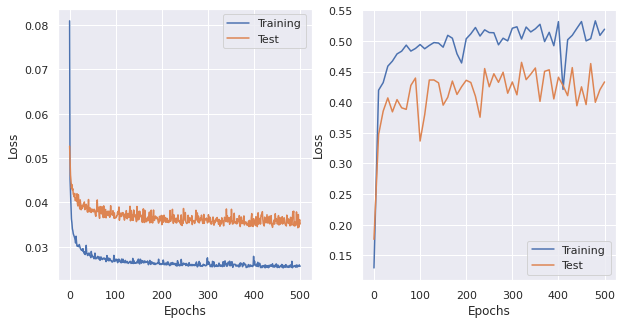

saving  ./plots/lr0.01LONGER_momentum0.1_wdecay0.001_dampening0_nesterovFalse.png

lr: 0.01, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
LogisticRegression(
  (fc1): Linear(in_features=47, out_features=1, bias=True)
)
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.2370. Test R^2: 0.1497. Loss Train: 0.0843. Loss Val: 0.0538. Time: 3.2603
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.4846. Test R^2: 0.4289. Loss Train: 0.0270. Loss Val: 0.0367. Time: 2.6736
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.5036. Test R^2: 0.4182. Loss Train: 0.0268. Loss Val: 0.0379. Time: 2.7447
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.5200. Test R^2: 0.4422. Loss Train: 0.0266. Loss Val: 0.0359. Time: 2.2237
 EPOCH 40. Progress: 8.0%. 
 Training R^2: 0.5165. Test R^2: 0.4516. Loss Train: 0.0260. Loss Val: 0.0370. Time: 7.8190
 EPOCH 50. Pr

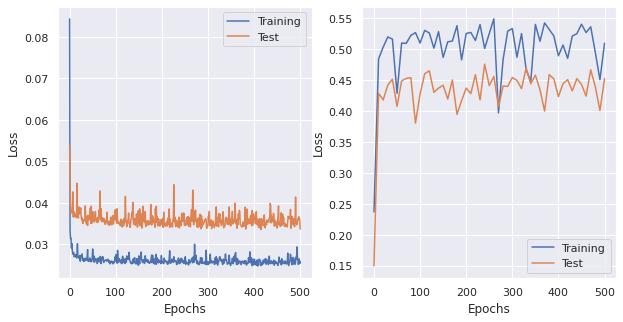

saving  ./plots/lr0.01LONGER_momentum0.9_wdecay0.001_dampening0_nesterovFalse.png


In [17]:
# Best configuration for longer
lr_range = [0.01]
weight_decay_range = [0.001]
momentum_range = [0.1,0.9]
dampening_range = [0]
nesterov_range = [False]
for lr in lr_range:
    for momentum in momentum_range:
        for weight_decay in weight_decay_range:
            for nesterov in nesterov_range:
                for dampening in dampening_range:
                    try: 
                        print('\nlr: {}, momentum: {}, weight_decay: {}, dampening: {}, nesterov: {} '.format(lr, momentum, weight_decay, dampening, nesterov))
                        model = LogisticRegression(in_dim=47,out_dim=1, verbose=False).to(device)
                        print(model)
                        SGD = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov) # This is absurdly high.
                        # initialize the loss function. You don't want to use this one, so change it accordingly
                        loss_fn = nn.MSELoss()
                        config_str = 'lr' + str(lr) + 'LONGER_momentum' + str(momentum) + '_wdecay' + str(weight_decay) + '_dampening' + str(dampening) +'_nesterov' + str(nesterov)
                        train(model,loss_fn, SGD, dataloaders['train'], dataloaders['val'], config_str,num_epochs=500, verbose=False)
                    except:
                        pass

In [18]:
# Test
with torch.no_grad():
    data, targets_val = next(iter(dataloaders['all_val']))
    model_input = data.to(device)
    predicted_val = model(model_input).squeeze()
#         _, predicted = torch.max(out, 1)
    print('predicted.shape: {}'.format(predicted_val.shape))
    print('predicted[:20]: \t{}'.format(predicted_val[:20]))
    print('targets[:20]: \t\t{}'.format(targets_val[:20]))
    
# Test
with torch.no_grad():
    data, targets = next(iter(dataloaders['test']))
    model_input = data.to(device)
    predicted = model(model_input).squeeze()
    print('predicted.shape: {}'.format(predicted.shape))
    print('predicted[:20]: \t{}'.format(predicted[:20]))
    print('targets[:20]: \t\t{}'.format(targets[:20]))

predicted.shape: torch.Size([335])
predicted[:20]: 	tensor([0.4197, 0.4249, 0.6119, 0.8562, 0.6343, 0.3911, 0.4445, 0.2016, 0.4953,
        0.5134, 0.2582, 0.4030, 0.3671, 0.4673, 0.5299, 0.7208, 0.5424, 0.1291,
        0.6937, 0.1303])
targets[:20]: 		tensor([0.3880, 0.2883, 0.7370, 0.9044, 0.5947, 0.5528, 0.3247, 0.1974, 0.5815,
        0.8917, 0.3609, 0.3433, 0.3853, 0.5961, 0.9056, 0.7102, 0.6711, 0.0362,
        0.5681, 0.2078])
predicted.shape: torch.Size([1118])
predicted[:20]: 	tensor([0.3200, 0.3313, 0.6222, 0.3567, 0.3359, 0.4297, 0.3794, 0.4444, 0.5455,
        0.5131, 0.5163, 0.5323, 0.5762, 0.5698, 0.5697, 0.5701, 0.5701, 0.5715,
        0.5823, 0.5200])
targets[:20]: 		tensor([0.0280, 0.1301, 0.2970, 0.2207, 0.2648, 0.3342, 0.2873, 0.3362, 0.6023,
        0.5031, 0.5335, 0.6247, 0.5454, 0.4926, 0.4442, 0.5030, 0.5472, 0.5128,
        0.5702, 0.5017])


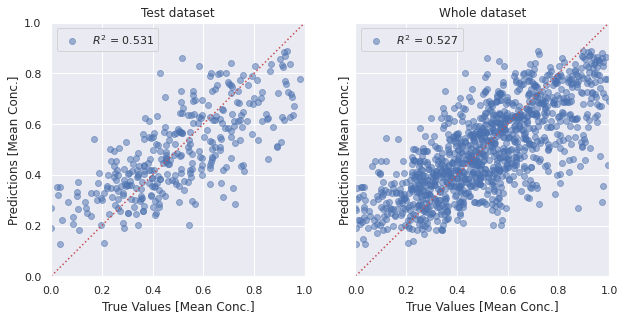

In [20]:
#Time for a real test
path_to_save = './plots'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
        
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)
# test_predictions = model(normed_test_data).flatten()
r = r2_score(targets_val, predicted_val.cpu())
ax1.scatter(targets_val, predicted_val.cpu(),alpha=0.5, label='$R^2$ = %.3f' % (r))
ax1.legend(loc="upper left")
ax1.set_xlabel('True Values [Mean Conc.]')
ax1.set_ylabel('Predictions [Mean Conc.]')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
_ = ax1.plot([-100, 100], [-100, 100], 'r:')
ax1.set_title('Test dataset')
fig.set_figheight(30)
fig.set_figwidth(10)

#Whole dataset
r = r2_score(targets, predicted.cpu())
ax2.scatter(targets, predicted.cpu(), alpha=0.5, label='$R^2$ = %.3f' % (r))
ax2.legend(loc="upper left")
ax2.set_xlabel('True Values [Mean Conc.]')
ax2.set_ylabel('Predictions [Mean Conc.]')
ax2.axis('equal')
ax2.axis('square')
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
_ = ax2.plot([-100, 100], [-100, 100], 'r:')
ax2.set_title('Whole dataset')
fig.savefig(os.path.join(path_to_save, 'LogisticReg_LONGER_R2Score_' + config_str + '.png'), bbox_inches='tight')


## Question 1

__What percentage classification accuracy did your simple network achieve? Make a table with the configurations you tested and results you obtained!__

### Feed-forward Neural Network

This time, keeping the rest of your logistic model fixed:
- Create one hidden layer (with 128 units) between the input and output by creating another weight and bias variable.
- Try training this without a non-linearity between the layers (linear activation), and then try adding a sigmoid non-linearity both before the hidden layer and after the hidden layer, recording your test accuracy results for each in a table.
- Try adjusting the learning rate (by making it smaller) if your model is not onverging/improving accuracy. You might also try increasing the number of epochs used.
- Experiment with the non-linearity used before the middle layer. Here are some activation functions to choose from: relu, softplus, elu, tanh.
- Lastly, experiment with the width of the hidden layer, keeping the activation function that performs best. Remember to add these results to your table.



In [21]:
class FeedForwardNet(nn.Module):
    def __init__(self, in_dim,hid_dim,out_dim,verbose=False):
        super(FeedForwardNet, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc2 = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        out = self.fc2(out)
        return out


lr: 0.001, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedForwardNet(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: -0.1002. Test R^2: -0.1883. Loss Train: 0.1547. Loss Val: 0.0770. Time: 2.8679
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.3881. Test R^2: 0.2935. Loss Train: 0.0333. Loss Val: 0.0443. Time: 2.2752
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.4002. Test R^2: 0.3021. Loss Train: 0.0306. Loss Val: 0.0407. Time: 7.0543
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.4327. Test R^2: 0.3883. Loss Train: 0.0296. Loss Val: 0.0408. Time: 2.1320
 EPOCH 40. Progress: 8.0%. 
 Training R^2: 0.4659. Test R^2: 0.3870. Loss Train: 0.0287. Loss Val: 0.0389. Time: 2.2508
 EPOCH 50. Progress: 10.0%. 
 Train

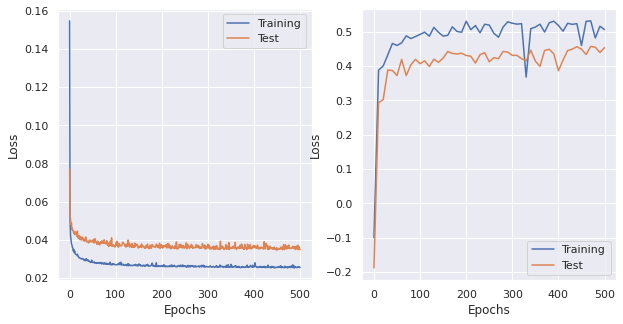

saving  ./plots/lr0.001FFNet_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim64.png

lr: 0.001, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedForwardNet(
  (fc1): Linear(in_features=47, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: -0.1650. Test R^2: 0.1370. Loss Train: 0.1189. Loss Val: 0.0560. Time: 2.2674
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.3564. Test R^2: 0.3440. Loss Train: 0.0348. Loss Val: 0.0429. Time: 3.4910
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.4045. Test R^2: 0.3636. Loss Train: 0.0316. Loss Val: 0.0414. Time: 2.2355
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.4447. Test R^2: 0.3739. Loss Train: 0.0294. Loss Val: 0.0425. Time: 2.1547
 EPOCH 40. Progress: 8.0%. 
 Training R^2: 0.4718. Test R^2: 0.

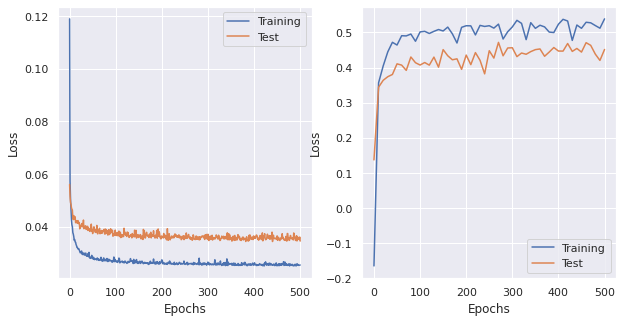

saving  ./plots/lr0.001FFNet_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim128.png


In [22]:
# Best configuration for longer
lr_range = [0.001]
hid_dim_range = [64,128]
weight_decay_range = [0.001]
momentum_range = [0.9]
dampening_range = [0]
nesterov_range = [False]
for lr in lr_range:
    for momentum in momentum_range:
        for weight_decay in weight_decay_range:
            for nesterov in nesterov_range:
                for dampening in dampening_range:
                    for hid_dim in hid_dim_range:
                        try: 
                            print('\nlr: {}, momentum: {}, weight_decay: {}, dampening: {}, nesterov: {} '.format(lr, momentum, weight_decay, dampening, nesterov))
                            model = FeedForwardNet(in_dim=47,hid_dim=hid_dim, out_dim=1, verbose=False).to(device)
                            print(model)
                            SGD = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov) # This is absurdly high.
                            # initialize the loss function. You don't want to use this one, so change it accordingly
                            loss_fn = nn.MSELoss()
                            config_str = 'lr' + str(lr) + 'FFNet_momentum' + str(momentum) + '_wdecay' + str(weight_decay) + '_dampening' + str(dampening) +'_nesterov' + str(nesterov) + '_HidDim' + str(hid_dim)
                            train(model,loss_fn, SGD, dataloaders['train'], dataloaders['val'], config_str,num_epochs=500, verbose=False)
                        except:
                            pass


lr: 0.1, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.3646. Test R^2: 0.3192. Loss Train: 0.0818. Loss Val: 0.0423. Time: 2.5027
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.1156. Test R^2: 0.0489. Loss Train: 0.0308. Loss Val: 0.0594. Time: 2.2376
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.5008. Test R^2: 0.3898. Loss Train: 0.0249. Loss Val: 0.0345. Time: 2.1767
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.4401. Test R^2: 0.4661. Loss Train: 0.0269. Loss Val: 0.0349. Time: 2.1309
 EPOCH 40. Progress: 8.0%. 
 Training R^2: 0.3220. Test R^2: 0.4064. Loss Train: 0.0248. Loss Val: 0.0372. Time: 2.3498
 EPOCH 50. Pr

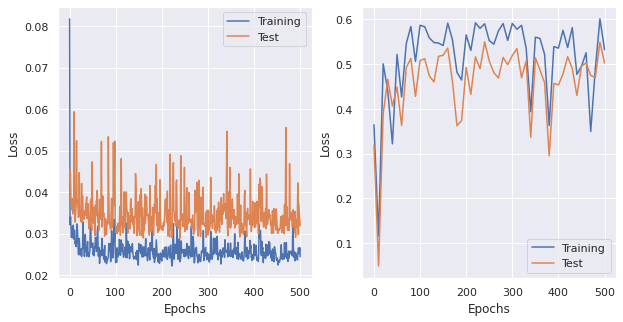

saving  ./plots/lr0.1FFNet_ReLU_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim64.png

lr: 0.1, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.2283. Test R^2: 0.2728. Loss Train: 0.0909. Loss Val: 0.0450. Time: 2.7173
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.5042. Test R^2: 0.3939. Loss Train: 0.0308. Loss Val: 0.0374. Time: 2.1023
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.4693. Test R^2: 0.4194. Loss Train: 0.0277. Loss Val: 0.0383. Time: 2.0253
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.5159. Test R^2: 0.4670. Loss Train: 0.0281. Loss Val: 0.0342. Time: 1.9902
 EPOCH 40. Progress: 8.0%. 
 Training

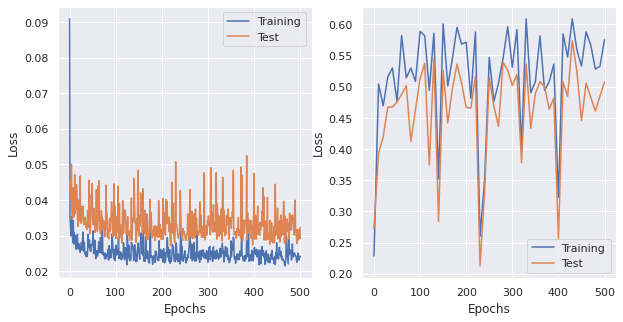

saving  ./plots/lr0.1FFNet_ReLU_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim128.png

lr: 0.01, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.2071. Test R^2: 0.1615. Loss Train: 0.0837. Loss Val: 0.0541. Time: 5.2521
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.4945. Test R^2: 0.4320. Loss Train: 0.0276. Loss Val: 0.0365. Time: 2.5691
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.4887. Test R^2: 0.3529. Loss Train: 0.0265. Loss Val: 0.0354. Time: 2.6201
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.4845. Test R^2: 0.3973. Loss Train: 0.0252. Loss Val: 0.0370. Time: 3.0503
 EPOCH 40. Progress: 8.0%. 
 Trainin

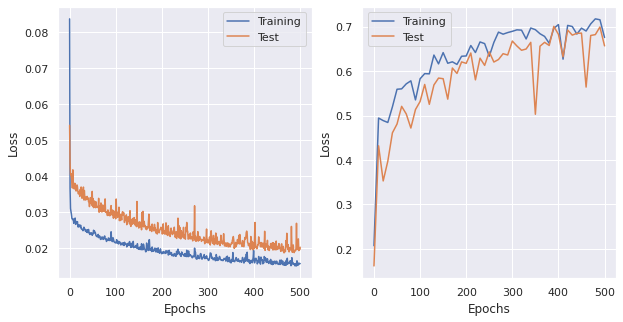

saving  ./plots/lr0.01FFNet_ReLU_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim64.png

lr: 0.01, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.1922. Test R^2: 0.1661. Loss Train: 0.0977. Loss Val: 0.0542. Time: 2.8262
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.4624. Test R^2: 0.3758. Loss Train: 0.0272. Loss Val: 0.0403. Time: 2.8381
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.5202. Test R^2: 0.4412. Loss Train: 0.0261. Loss Val: 0.0368. Time: 2.4058
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.5272. Test R^2: 0.4667. Loss Train: 0.0244. Loss Val: 0.0363. Time: 2.6949
 EPOCH 40. Progress: 8.0%. 
 Train

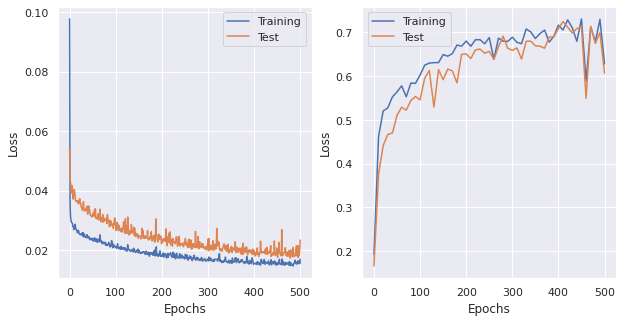

saving  ./plots/lr0.01FFNet_ReLU_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim128.png


In [23]:
# Testing a regular FFnet
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(in_dim, hid_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hid_dim, out_dim)  

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out

# Best configuration for longer
lr_range = [0.1,0.01]
hid_dim_range = [64,128]
weight_decay_range = [0.001]
momentum_range = [0.9]
dampening_range = [0]
nesterov_range = [False]
for lr in lr_range:
    for momentum in momentum_range:
        for weight_decay in weight_decay_range:
            for nesterov in nesterov_range:
                for dampening in dampening_range:
                    for hid_dim in hid_dim_range:
#                         try: 
                        print('\nlr: {}, momentum: {}, weight_decay: {}, dampening: {}, nesterov: {} '.format(lr, momentum, weight_decay, dampening, nesterov))
                        model = FeedforwardNeuralNetModel(in_dim=47,hid_dim=hid_dim, out_dim=1).to(device)
                        print(model)
                        SGD = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov) # This is absurdly high.
                        # initialize the loss function. You don't want to use this one, so change it accordingly
                        loss_fn = nn.MSELoss()
                        config_str = 'lr' + str(lr) + 'FFNet_ReLU_momentum' + str(momentum) + '_wdecay' + str(weight_decay) + '_dampening' + str(dampening) +'_nesterov' + str(nesterov) + '_HidDim' + str(hid_dim)
                        train(model,loss_fn, SGD, dataloaders['train'], dataloaders['val'], config_str,num_epochs=500, verbose=False)
#                         except:
#                             pass


lr: 0.01, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0.001
)
n. of epochs: 1000
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.2232. Test R^2: 0.2320. Loss Train: 0.0805. Loss Val: 0.0466. Time: 2.9867
 EPOCH 10. Progress: 1.0%. 
 Training R^2: 0.4549. Test R^2: 0.3706. Loss Train: 0.0290. Loss Val: 0.0387. Time: 3.3358
 EPOCH 20. Progress: 2.0%. 
 Training R^2: 0.5057. Test R^2: 0.4227. Loss Train: 0.0263. Loss Val: 0.0358. Time: 2.7223
 EPOCH 30. Progress: 3.0%. 
 Training R^2: 0.5079. Test R^2: 0.4562. Loss Train: 0.0252. Loss Val: 0.0335. Time: 2.2713
 EPOCH 40. Progress: 4.0%. 
 Training R^2: 0.5576. Test R^2: 0.4683. Loss Train: 0.0244. Loss Val: 0.0334. Time: 2.2900
 EPOCH 50.

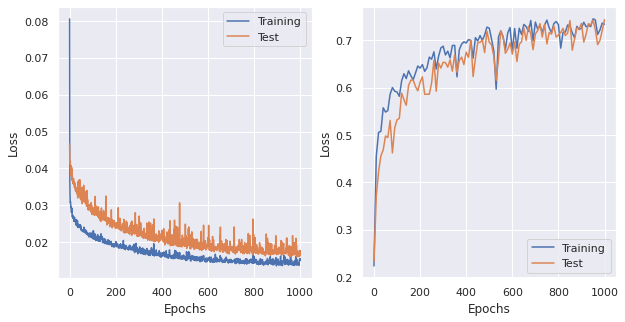

saving  ./plots/LONGER_FFNet_ReLU_lr0.01_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim64.png


In [24]:
# Training the best for longer
# Testing a regular FFnet
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(in_dim, hid_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hid_dim, out_dim)  

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out

# Best configuration for longer
lr_range = [0.01]
hid_dim_range = [64]
weight_decay_range = [0.001]
momentum_range = [0.9]
dampening_range = [0]
nesterov_range = [False]
for lr in lr_range:
    for momentum in momentum_range:
        for weight_decay in weight_decay_range:
            for nesterov in nesterov_range:
                for dampening in dampening_range:
                    for hid_dim in hid_dim_range:
#                         try: 
                        print('\nlr: {}, momentum: {}, weight_decay: {}, dampening: {}, nesterov: {} '.format(lr, momentum, weight_decay, dampening, nesterov))
                        model = FeedforwardNeuralNetModel(in_dim=47,hid_dim=hid_dim, out_dim=1).to(device)
                        print(model)
                        SGD = torch.optim.SGD(model.parameters(), lr = lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov) # This is absurdly high.
                        # initialize the loss function. You don't want to use this one, so change it accordingly
                        loss_fn = nn.MSELoss()
                        config_str = 'LONGER_FFNet_ReLU_lr' + str(lr) + '_momentum' + str(momentum) + '_wdecay' + str(weight_decay) + '_dampening' + str(dampening) +'_nesterov' + str(nesterov) + '_HidDim' + str(hid_dim)
                        train(model,loss_fn, SGD, dataloaders['train'], dataloaders['val'], config_str,num_epochs=1000, verbose=False)
#                         except:
#                             pass

predicted.shape: torch.Size([335])
predicted[:20]: 	tensor([0.5857, 0.5157, 0.6183, 0.4734, 0.4436, 0.3312, 0.6941, 0.7504, 0.5765,
        0.1581, 0.6536, 0.8482, 0.3342, 0.6194, 0.4693, 0.5088, 0.6190, 0.2262,
        0.6980, 0.4626])
targets[:20]: 		tensor([0.5908, 0.3096, 0.5722, 0.6008, 0.4230, 0.1593, 0.6624, 0.7025, 0.5815,
        0.1031, 0.5105, 0.9683, 0.2082, 0.6711, 0.5554, 0.6664, 0.4915, 0.1425,
        0.6479, 0.5573])
predicted.shape: torch.Size([1118])
predicted[:20]: 	tensor([0.2354, 0.2575, 0.4211, 0.2812, 0.2703, 0.4035, 0.3168, 0.4194, 0.5279,
        0.5243, 0.5281, 0.5377, 0.5387, 0.5360, 0.5383, 0.5388, 0.5388, 0.5397,
        0.5434, 0.5010])
targets[:20]: 		tensor([0.0280, 0.1301, 0.2970, 0.2207, 0.2648, 0.3342, 0.2873, 0.3362, 0.6023,
        0.5031, 0.5335, 0.6247, 0.5454, 0.4926, 0.4442, 0.5030, 0.5472, 0.5128,
        0.5702, 0.5017])


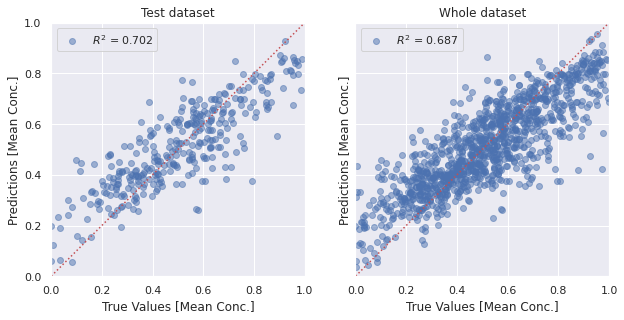

In [26]:
# Test
with torch.no_grad():
    data, targets_val = next(iter(dataloaders['all_val']))
    model_input = data.to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    predicted_val = model(model_input).squeeze()
#         _, predicted = torch.max(out, 1)
    print('predicted.shape: {}'.format(predicted_val.shape))
    print('predicted[:20]: \t{}'.format(predicted_val[:20]))
    print('targets[:20]: \t\t{}'.format(targets_val[:20]))
    
# Test
with torch.no_grad():
    data, targets = next(iter(dataloaders['test']))
    model_input = data.to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    predicted = model(model_input).squeeze()
    print('predicted.shape: {}'.format(predicted.shape))
    print('predicted[:20]: \t{}'.format(predicted[:20]))
    print('targets[:20]: \t\t{}'.format(targets[:20]))
    
#Time for a real test
path_to_save = './plots'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
        
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)
# test_predictions = model(normed_test_data).flatten()
r = r2_score(targets_val, predicted_val.cpu())
ax1.scatter(targets_val, predicted_val.cpu(),alpha=0.5, label='$R^2$ = %.3f' % (r))
ax1.legend(loc="upper left")
ax1.set_xlabel('True Values [Mean Conc.]')
ax1.set_ylabel('Predictions [Mean Conc.]')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
_ = ax1.plot([-100, 100], [-100, 100], 'r:')
ax1.set_title('Test dataset')
fig.set_figheight(30)
fig.set_figwidth(10)
#plt.show()
#plt.close('all')

#Whole dataset
# dataset_predictions = model.predict(normed_dataset).flatten()
r = r2_score(targets, predicted.cpu())
ax2.scatter(targets, predicted.cpu(), alpha=0.5, label='$R^2$ = %.3f' % (r))
ax2.legend(loc="upper left")
ax2.set_xlabel('True Values [Mean Conc.]')
ax2.set_ylabel('Predictions [Mean Conc.]')
ax2.axis('equal')
ax2.axis('square')
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
_ = ax2.plot([-100, 100], [-100, 100], 'r:')
ax2.set_title('Whole dataset')
# plt.show()
fig.savefig(os.path.join(path_to_save, 'FFNet_LONGER_R2Score_' + config_str + '.png'), bbox_inches='tight')
# #plt.close('all')


lr: 0.01, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
n. of epochs: 1000
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.3907. Test R^2: 0.3027. Loss Train: 0.0637. Loss Val: 0.0418. Time: 2.5571
 EPOCH 10. Progress: 1.0%. 
 Training R^2: 0.5283. Test R^2: 0.4687. Loss Train: 0.0272. Loss Val: 0.0335. Time: 2.3194
 EPOCH 20. Progress: 2.0%. 
 Training R^2: 0.5861. Test R^2: 0.5017. Loss Train: 0.0250. Loss Val: 0.0318. Time: 2.1796
 EPOCH 30. Progress: 3.0%. 
 Training R^2: 0.5841. Test R^2: 0.5459. Loss Train: 0.0249. Loss Val: 0.0283. Time: 2.1632
 EPOCH 40. Progress: 4.0%. 
 Training R^2: 0.4285. Test R^2: 0.3964. Loss Train: 0.0226. Loss Val: 0.0375. Time: 2.2345
 EPOCH 50.

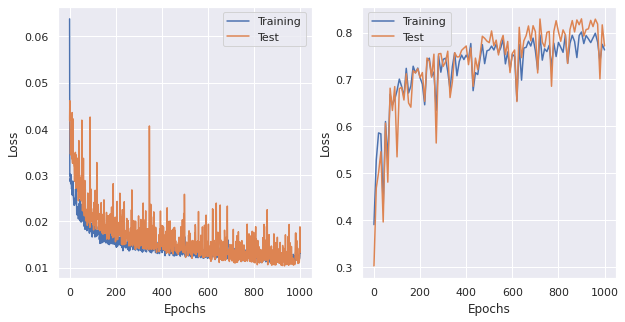

saving  ./plots/LONGER_ADAM_FFNet_ReLU_lr0.01_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim64.png

lr: 0.001, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
n. of epochs: 1000
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.2028. Test R^2: 0.1560. Loss Train: 0.0692. Loss Val: 0.0486. Time: 2.3983
 EPOCH 10. Progress: 1.0%. 
 Training R^2: 0.4759. Test R^2: 0.4325. Loss Train: 0.0263. Loss Val: 0.0361. Time: 2.0657
 EPOCH 20. Progress: 2.0%. 
 Training R^2: 0.5427. Test R^2: 0.4802. Loss Train: 0.0245. Loss Val: 0.0329. Time: 2.7306
 EPOCH 30. Progress: 3.0%. 
 Training R^2: 0.5391. Test R^2: 0.5306. Loss Train: 0.0224. Loss Val: 0.0307. Time: 2.2783
 EPOCH 40. Progress:

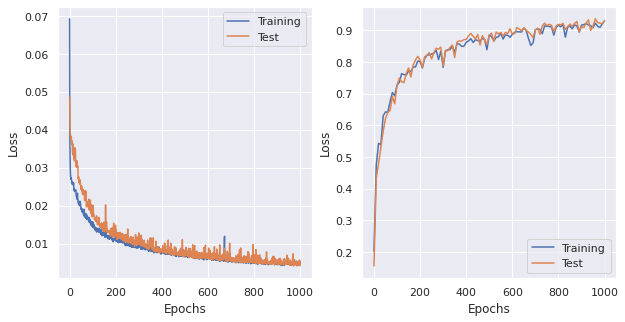

saving  ./plots/LONGER_ADAM_FFNet_ReLU_lr0.001_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim64.png


In [27]:
# Trying ADAM
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(in_dim, hid_dim) 
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hid_dim, out_dim)  

    def forward(self, x):
        # Linear function
        out = self.fc1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear function (readout)
        out = self.fc2(out)
        return out

# Best configuration for longer
lr_range = [0.01,0.001]
hid_dim_range = [64]
weight_decay_range = [0.001]
momentum_range = [0.9]
dampening_range = [0]
nesterov_range = [False]
for lr in lr_range:
    for hid_dim in hid_dim_range:
        print('\nlr: {}, momentum: {}, weight_decay: {}, dampening: {}, nesterov: {} '.format(lr, momentum, weight_decay, dampening, nesterov))
        model = FeedforwardNeuralNetModel(in_dim=47,hid_dim=hid_dim, out_dim=1).to(device)
        print(model)
        SGD = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
        # initialize the loss function. You don't want to use this one, so change it accordingly
        loss_fn = nn.MSELoss().to(device)
        config_str = 'LONGER_ADAM_FFNet_ReLU_lr' + str(lr) + '_momentum' + str(momentum) + '_wdecay' + str(weight_decay) + '_dampening' + str(dampening) +'_nesterov' + str(nesterov) + '_HidDim' + str(hid_dim)
        train(model,loss_fn, SGD, dataloaders['train'], dataloaders['val'], config_str,num_epochs=1000, verbose=False)

predicted.shape: torch.Size([335])
predicted[:20]: 	tensor([0.3208, 0.7937, 0.8534, 0.3528, 0.4023, 0.1810, 0.3304, 0.0766, 0.8246,
        0.6655, 0.2339, 0.2251, 0.4263, 0.6891, 0.7257, 0.3355, 0.6974, 0.3572,
        0.8831, 0.2559])
targets[:20]: 		tensor([0.8422, 0.7139, 0.8761, 0.5382, 0.2834, 0.1301, 0.3854, 0.2266, 0.8438,
        0.6774, 0.3873, 0.4123, 0.4433, 0.8151, 0.7777, 0.3105, 0.6314, 0.3211,
        0.8954, 0.2512])
predicted.shape: torch.Size([1118])
predicted[:20]: 	tensor([0.0556, 0.1810, 0.2741, 0.1903, 0.2008, 0.2848, 0.2288, 0.3241, 0.5576,
        0.5037, 0.4970, 0.5641, 0.5313, 0.5002, 0.4886, 0.4925, 0.4925, 0.4964,
        0.5011, 0.4783])
targets[:20]: 		tensor([0.0280, 0.1301, 0.2970, 0.2207, 0.2648, 0.3342, 0.2873, 0.3362, 0.6023,
        0.5031, 0.5335, 0.6247, 0.5454, 0.4926, 0.4442, 0.5030, 0.5472, 0.5128,
        0.5702, 0.5017])


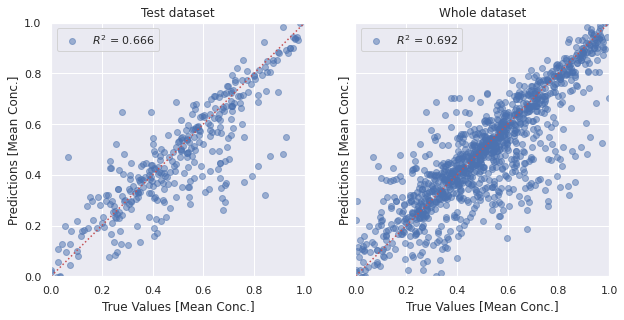

In [29]:
# Test
with torch.no_grad():
    data, targets_val = next(iter(dataloaders['all_val']))
    model_input = data.to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    predicted_val = model(model_input).squeeze()
#         _, predicted = torch.max(out, 1)
    print('predicted.shape: {}'.format(predicted_val.shape))
    print('predicted[:20]: \t{}'.format(predicted_val[:20]))
    print('targets[:20]: \t\t{}'.format(targets_val[:20]))
    
# Test
with torch.no_grad():
    data, targets = next(iter(dataloaders['test']))
    model_input = data.to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    predicted = model(model_input).squeeze()
    print('predicted.shape: {}'.format(predicted.shape))
    print('predicted[:20]: \t{}'.format(predicted[:20]))
    print('targets[:20]: \t\t{}'.format(targets[:20]))
    
#Time for a real test
path_to_save = './plots'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
        
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)
# test_predictions = model(normed_test_data).flatten()
r = r2_score(targets_val, predicted_val.cpu())
ax1.scatter(targets_val, predicted_val.cpu(),alpha=0.5, label='$R^2$ = %.3f' % (r))
ax1.legend(loc="upper left")
ax1.set_xlabel('True Values [Mean Conc.]')
ax1.set_ylabel('Predictions [Mean Conc.]')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
_ = ax1.plot([-100, 100], [-100, 100], 'r:')
ax1.set_title('Test dataset')
fig.set_figheight(30)
fig.set_figwidth(10)
#plt.show()
#plt.close('all')

#Whole dataset
# dataset_predictions = model.predict(normed_dataset).flatten()
r = r2_score(targets, predicted.cpu())
ax2.scatter(targets, predicted.cpu(), alpha=0.5, label='$R^2$ = %.3f' % (r))
ax2.legend(loc="upper left")
ax2.set_xlabel('True Values [Mean Conc.]')
ax2.set_ylabel('Predictions [Mean Conc.]')
ax2.axis('equal')
ax2.axis('square')
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
_ = ax2.plot([-100, 100], [-100, 100], 'r:')
ax2.set_title('Whole dataset')
# plt.show()
fig.savefig(os.path.join(path_to_save, 'FFNet_ADAM_LONGER_R2Score_' + config_str + '.png'), bbox_inches='tight')
# #plt.close('all')


lr: 0.001, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: -0.1116. Test R^2: -0.0033. Loss Train: 0.1149. Loss Val: 0.0621. Time: 3.7105
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.4195. Test R^2: 0.3340. Loss Train: 0.0315. Loss Val: 0.0411. Time: 3.9621
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.4887. Test R^2: 0.4492. Loss Train: 0.0295. Loss Val: 0.0366. Time: 2.6475
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.5252. Test R^2: 0.4602. Loss Train: 0.0255. Loss Val: 0.0329. Time: 2.6859
 EPOCH 40. Progress: 8.0%. 

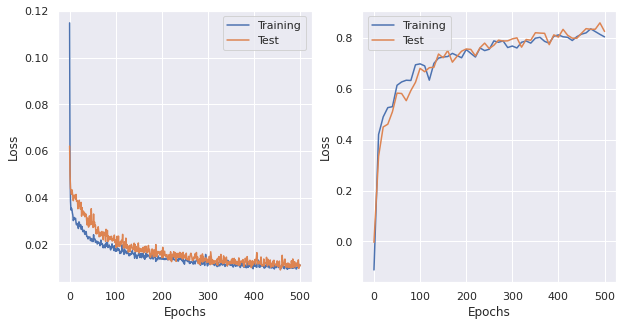

saving  ./plots/lr0.001_3FFNet_2ReLU_Drop_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim64.png

lr: 0.001, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=128, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.1006. Test R^2: 0.1840. Loss Train: 0.0998. Loss Val: 0.0517. Time: 2.6534
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.4191. Test R^2: 0.3644. Loss Train: 0.0283. Loss Val: 0.0408. Time: 2.6442
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.5341. Test R^2: 0.5072. Loss Train: 0.0266. Loss Val: 0.0310. Time: 2.4408
 EPOCH 30. Progress: 6.0%. 
 Training R^2

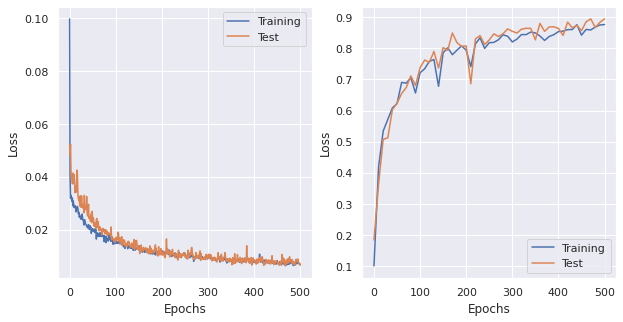

saving  ./plots/lr0.001_3FFNet_2ReLU_Drop_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim128.png

lr: 0.01, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.2998. Test R^2: 0.2777. Loss Train: 0.0643. Loss Val: 0.0466. Time: 2.5134
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.3839. Test R^2: 0.2695. Loss Train: 0.0285. Loss Val: 0.0448. Time: 2.4105
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.5141. Test R^2: 0.3926. Loss Train: 0.0257. Loss Val: 0.0333. Time: 2.2853
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0.5

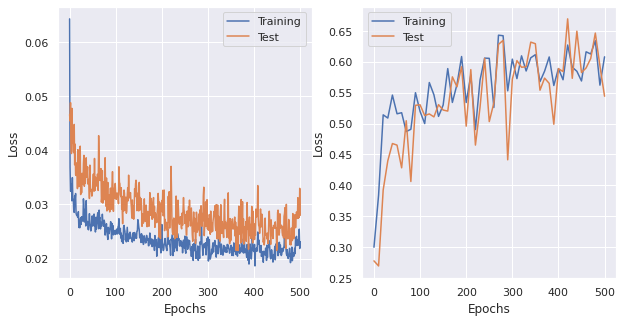

saving  ./plots/lr0.01_3FFNet_2ReLU_Drop_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim64.png

lr: 0.01, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=128, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
n. of epochs: 500
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.3500. Test R^2: 0.2949. Loss Train: 0.0595. Loss Val: 0.0439. Time: 1.9680
 EPOCH 10. Progress: 2.0%. 
 Training R^2: 0.4798. Test R^2: 0.4110. Loss Train: 0.0307. Loss Val: 0.0393. Time: 2.0753
 EPOCH 20. Progress: 4.0%. 
 Training R^2: 0.5034. Test R^2: 0.4412. Loss Train: 0.0277. Loss Val: 0.0351. Time: 2.0036
 EPOCH 30. Progress: 6.0%. 
 Training R^2: 0

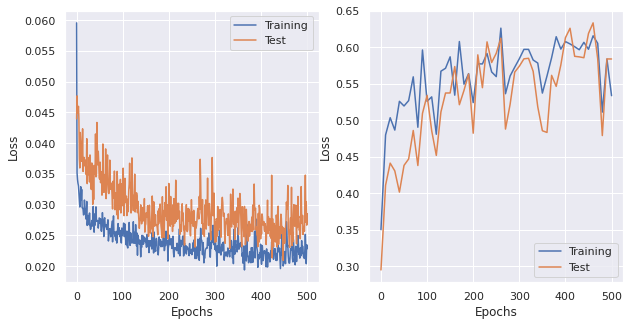

saving  ./plots/lr0.01_3FFNet_2ReLU_Drop_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim128.png


In [30]:
# Testing a regular FFnet
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.drop = nn.Dropout(0.2)
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function
        out = self.relu(self.fc1(x))
        out = self.drop(out)
        out = self.relu(self.fc2(out))
        out = self.drop(out)
        out = self.fc3(out)
        return out

# Best configuration for longer
lr_range = [0.001,0.01]
hid_dim_range = [64,128]
weight_decay_range = [0.001]
momentum_range = [0.9]
dampening_range = [0]
nesterov_range = [False]
for lr in lr_range:
    for momentum in momentum_range:
        for weight_decay in weight_decay_range:
            for nesterov in nesterov_range:
                for dampening in dampening_range:
                    for hid_dim in hid_dim_range:
                        print('\nlr: {}, momentum: {}, weight_decay: {}, dampening: {}, nesterov: {} '.format(lr, momentum, weight_decay, dampening, nesterov))
                        model = FeedforwardNeuralNetModel(input_dim=47,hidden_dim=hid_dim, output_dim=1).to(device)
                        print(model)
                        SGD = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
                        loss_fn = nn.MSELoss().to(device)
                        config_str = 'lr' + str(lr) + '_3FFNet_2ReLU_Drop_momentum' + str(momentum) + '_wdecay' + str(weight_decay) + '_dampening' + str(dampening) +'_nesterov' + str(nesterov) + '_HidDim' + str(hid_dim)
                        train(model,loss_fn, SGD, dataloaders['train'], dataloaders['val'], config_str,num_epochs=500, verbose=False)


lr: 0.001, momentum: 0.9, weight_decay: 0.001, dampening: 0, nesterov: False 
FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=47, out_features=128, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
n. of epochs: 1000
 EPOCH 0. Progress: 0.0%. 
 Training R^2: 0.0927. Test R^2: 0.0356. Loss Train: 0.1167. Loss Val: 0.0563. Time: 3.3496
 EPOCH 10. Progress: 1.0%. 
 Training R^2: 0.4223. Test R^2: 0.4131. Loss Train: 0.0295. Loss Val: 0.0375. Time: 2.4228
 EPOCH 20. Progress: 2.0%. 
 Training R^2: 0.5436. Test R^2: 0.5038. Loss Train: 0.0266. Loss Val: 0.0323. Time: 2.4585
 EPOCH 30. Progress: 3.0%. 
 Training R^2: 0.5576. Test R^2: 0.5039. Loss Train: 0.0248. Loss Val: 0.0303. Time: 2.6364
 EPOCH 40. Progress: 4.0

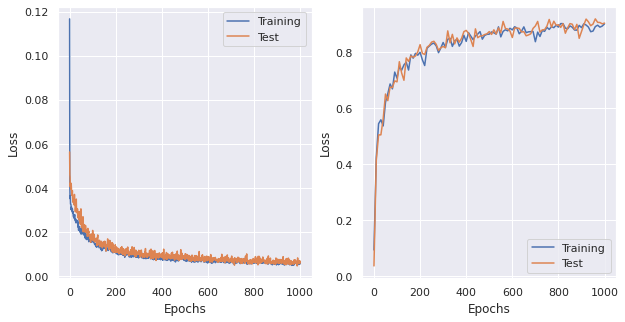

saving  ./plots/lr0.001_3FFNet_2ReLU_Drop_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim128.png


In [31]:
# ./plots/lr0.001_3FFNet_2ReLU_Drop_momentum0.9_wdecay0.001_dampening0_nesterovFalse_HidDim128.png
# Testing a regular FFnet
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.drop = nn.Dropout(0.2)
        # Non-linearity
        self.relu = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function
        out = self.relu(self.fc1(x))
        out = self.drop(out)
        out = self.relu(self.fc2(out))
        out = self.drop(out)
        out = self.fc3(out)
        return out

# Best configuration for longer
lr_range = [0.001]
hid_dim_range = [128]
weight_decay_range = [0.001]
momentum_range = [0.9]
dampening_range = [0]
nesterov_range = [False]
for lr in lr_range:
    for momentum in momentum_range:
        for weight_decay in weight_decay_range:
            for nesterov in nesterov_range:
                for dampening in dampening_range:
                    for hid_dim in hid_dim_range:
                        print('\nlr: {}, momentum: {}, weight_decay: {}, dampening: {}, nesterov: {} '.format(lr, momentum, weight_decay, dampening, nesterov))
                        model = FeedforwardNeuralNetModel(input_dim=47,hidden_dim=hid_dim, output_dim=1).to(device)
                        print(model)
                        SGD = torch.optim.Adam(model.parameters(), lr = lr) # This is absurdly high.
                        loss_fn = nn.MSELoss().to(device)
                        config_str = 'lr' + str(lr) + '_3FFNet_2ReLU_Drop_momentum' + str(momentum) + '_wdecay' + str(weight_decay) + '_dampening' + str(dampening) +'_nesterov' + str(nesterov) + '_HidDim' + str(hid_dim)
                        train(model,loss_fn, SGD, dataloaders['train'], dataloaders['val'], config_str,num_epochs=1000, verbose=False)

predicted.shape: torch.Size([335])
predicted[:20]: 	tensor([ 0.8374,  0.4542,  0.3902,  0.4156,  0.7975,  0.6249,  0.4712,  0.2219,
         0.6796,  0.5515,  0.0676,  0.5882,  0.6912,  0.6129, -0.0232,  0.1744,
         0.7455,  0.0933,  0.4177,  0.4790])
targets[:20]: 		tensor([0.9596, 0.4605, 0.8906, 0.3956, 0.8300, 0.6755, 0.6471, 0.1907, 0.6822,
        0.5598, 0.0016, 0.5665, 0.6302, 0.6531, 0.0855, 0.1301, 0.6856, 0.2712,
        0.6779, 0.5099])
predicted.shape: torch.Size([1118])
predicted[:20]: 	tensor([0.0534, 0.2025, 0.3275, 0.2179, 0.1938, 0.2668, 0.3248, 0.3472, 0.5163,
        0.5817, 0.5051, 0.5089, 0.4742, 0.5025, 0.5184, 0.5432, 0.5099, 0.5161,
        0.5317, 0.4993])
targets[:20]: 		tensor([0.0280, 0.1301, 0.2970, 0.2207, 0.2648, 0.3342, 0.2873, 0.3362, 0.6023,
        0.5031, 0.5335, 0.6247, 0.5454, 0.4926, 0.4442, 0.5030, 0.5472, 0.5128,
        0.5702, 0.5017])


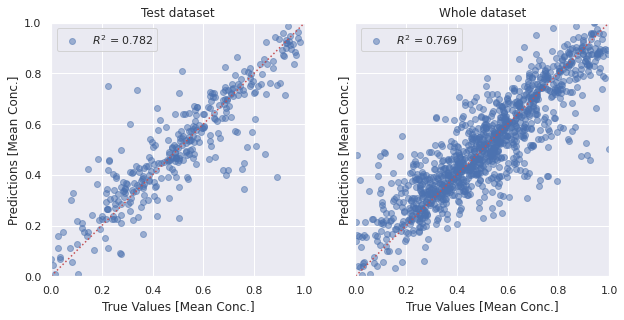

In [32]:
# Test
with torch.no_grad():
    data, targets_val = next(iter(dataloaders['all_val']))
    model_input = data.to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    predicted_val = model(model_input).squeeze()
#         _, predicted = torch.max(out, 1)
    print('predicted.shape: {}'.format(predicted_val.shape))
    print('predicted[:20]: \t{}'.format(predicted_val[:20]))
    print('targets[:20]: \t\t{}'.format(targets_val[:20]))
    
# Test
with torch.no_grad():
    data, targets = next(iter(dataloaders['test']))
    model_input = data.to(device)# TODO: Turn the 28 by 28 image tensors into a 784 dimensional tensor.
    predicted = model(model_input).squeeze()
    print('predicted.shape: {}'.format(predicted.shape))
    print('predicted[:20]: \t{}'.format(predicted[:20]))
    print('targets[:20]: \t\t{}'.format(targets[:20]))
    
#Time for a real test
path_to_save = './plots'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
        
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True)
# test_predictions = model(normed_test_data).flatten()
r = r2_score(targets_val, predicted_val.cpu())
ax1.scatter(targets_val, predicted_val.cpu(),alpha=0.5, label='$R^2$ = %.3f' % (r))
ax1.legend(loc="upper left")
ax1.set_xlabel('True Values [Mean Conc.]')
ax1.set_ylabel('Predictions [Mean Conc.]')
ax1.axis('equal')
ax1.axis('square')
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
_ = ax1.plot([-100, 100], [-100, 100], 'r:')
ax1.set_title('Test dataset')
fig.set_figheight(30)
fig.set_figwidth(10)
#plt.show()
#plt.close('all')

#Whole dataset
# dataset_predictions = model.predict(normed_dataset).flatten()
r = r2_score(targets, predicted.cpu())
ax2.scatter(targets, predicted.cpu(), alpha=0.5, label='$R^2$ = %.3f' % (r))
ax2.legend(loc="upper left")
ax2.set_xlabel('True Values [Mean Conc.]')
ax2.set_ylabel('Predictions [Mean Conc.]')
ax2.axis('equal')
ax2.axis('square')
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
_ = ax2.plot([-100, 100], [-100, 100], 'r:')
ax2.set_title('Whole dataset')
# plt.show()
fig.savefig(os.path.join(path_to_save, '3FFNet_2ReLU_Drop_ADAM_LONGER_R2Score_' + config_str + '.png'), bbox_inches='tight')
# #plt.close('all')